# Extract EEG Data

Extract data of interst from ChildMind dataset.

In [1]:
%matplotlib inline

import os
import csv
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import mne

In [2]:
# Import custom project related code
import sys
sys.path.append('../code')

from db import EEGDB

## Settings

In [3]:
# Set MNE verbosity level & shut up some warnings
mne.set_log_level(verbose=False)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
# Data info / parameters
s_freq = 500

### Subjects

In [5]:
# Initialize project database object
data_path = '/Volumes/Data/Data/03-External/Childmind'
db = EEGDB(data_path=data_path)

In [6]:
# Load data readme file
rmd_file = os.path.join(db.data_path, 'EEG', 'MIPDB_PublicFile.csv')
df = pd.read_csv(rmd_file)

In [7]:
# Set subject to run
#cur_subj = subjs[10]
cur_subj = 'A00051826'

# Get subject data files
data_files, event_files, _ = db.get_subj_files(cur_subj)

In [8]:
# Get the indices of the resting state data and event files
try:
    event_ind = [ef.split('_')[1][-3:] for ef in event_files].index('001')
    data_ind = [df.split('.')[0][-3:] for df in data_files].index('001')
except(ValueError):
    print('Files not found. Can not proceed.')

In [9]:
# Get file file path for data file & associated event file
data_file = data_files[data_ind]
data_f_name = db.gen_data_path(cur_subj, data_file)

event_file = event_files[event_ind]
event_f_name = db.gen_data_path(cur_subj, event_file)

In [10]:
# Check file names
print(data_file)
print(event_file)

assert data_file.split('.')[0][-3:] == '001'
assert event_file.split('.')[0][-10:-7] == '001'

gp_A00051826001.csv
gp_A00051826001_events.csv


In [11]:
# Load data file
data = np.loadtxt(data_f_name, delimiter=',')

In [12]:
# Get subject age
age = df[df['ID'] == cur_subj].Age.values[0]

In [13]:
# Read in list of channel names that are kept in reduced 111 montage
with open('../data/chans111.csv', 'r') as csv_file:
    reader = csv.reader(csv_file)
    ch_labels = list(reader)[0]

In [14]:
# Read montage, reduced to 111 channel selection
#montage = mne.channels.read_montage('GSN-HydroCel-129', ch_names=ch_labels)

# Read channel montage
montage = mne.channels.make_standard_montage('GSN-HydroCel-129')

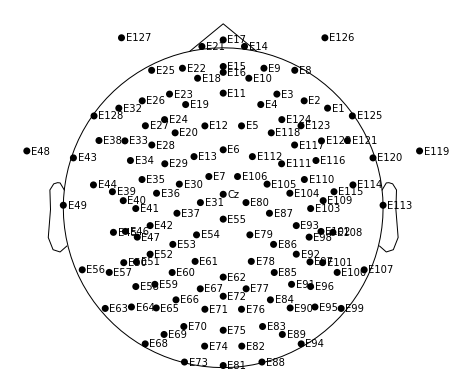

In [15]:
# Check out the montage plot
montage.plot();

In [16]:
# Create the info structure needed by MNE
info = mne.create_info(ch_labels, s_freq, 'eeg')
info.set_montage(montage)

# Create the MNE Raw data object
raw = mne.io.RawArray(data, info)

In [17]:
# Create a stim channel
stim_info = mne.create_info(['stim'], s_freq, 'stim')
stim_raw = mne.io.RawArray(np.zeros(shape=[1, len(raw.times)]), stim_info)

In [18]:
# Add stim channel to data object
raw.add_channels([stim_raw], force_update_info=True);

#### Load Events from File

In [19]:
# Initialize headers and variable to store event info
headers = ['type', 'value', 'latency', 'duration', 'urevent']
evs = np.empty(shape=[0, 3])

# Load events from csv file
with open(event_f_name, 'r') as csv_file:
    
    reader = csv.reader(csv_file)
    for row in reader:

        # Skip the empty rows & the header rows
        if row == []: continue
        if row[0] == 'type': continue
        
        # Collect actual event data rows
        evs = np.vstack((evs, np.array([int(row[2]), 0, int(row[0])])))
    
    # Drop any events that are outside the recorded EEG range
    evs = evs[np.invert(evs[:, 0] > data.shape[1])]

# Add events to data object
raw.add_events(evs, stim_channel='stim')

# Check events
data_evs = mne.find_events(raw)

In [20]:
# Find flat channels and set them as bad
flat_inds = np.mean(raw._data[:111, :], axis=1) == 0
flat_chans = list(np.array(raw.ch_names[:111])[flat_inds])
raw.info['bads'] = flat_chans
print('Bad channels: ', raw.info['bads'])

Bad channels:  ['E1', 'E8', 'E14', 'E21', 'E25', 'E32']


In [21]:
# Interpolate bad channels
raw.interpolate_bads();

In [22]:
# Set average reference
raw.set_eeg_reference()
raw.apply_proj();

## Resting EEG event descriptions

- 90: Start of the resting EEG paradigm
- 20: Eyes open start (20 seconds)
- 30: Eyes closed start (40 seconds)

^ There should be 5 of each EO and EC

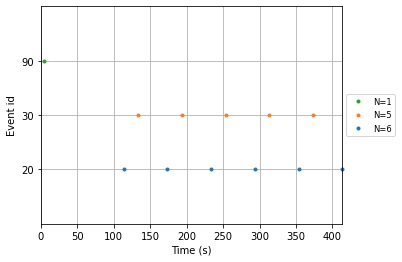

In [23]:
_ = mne.viz.plot_events(data_evs, raw.info['sfreq'])

In [24]:
# Get good eeg channel indices
eeg_chans = mne.pick_types(raw.info, meg=False, eeg=True)

# Epoch resting eeg data events
eo_epochs = mne.Epochs(raw, events=data_evs, event_id={'EO': 20}, tmin=0, tmax=20,
                       baseline=None, picks=eeg_chans, preload=True)
ec_epochs = mne.Epochs(raw, events=data_evs, event_id={'EC': 30}, tmin=5, tmax=35,
                       baseline=None, picks=eeg_chans, preload=True)

In [25]:
# Get data for specified channel
data = ec_epochs.get_data()
cz_data = data[0, raw.ch_names.index('Cz'), :]